In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <책 내용>

전 chapter에서 epsilon-Greedy 알고리즘을 완전히 구현하긴 했지만,

알고리즘을 실제로 실행하지는 않아서 여전히 매우 추상적인 논의였음

왜 Bandit 알고리즘을 디버깅하는 게 어려운가?

일반적인 머신러닝 모델은 이미 존재하는 데이터셋을 받아서 학습함 (batch learning)

하지만 Bandit 알고리즘은 스스로 어떤 데이터를 받을지를 결정해야 함

예: “광고를 어떤 사용자에게 보여줄까?”, “어떤 광고를 띄울까?”를 스스로 정함

이 과정에서 얻는 보상(reward) 또한 확률적으로 주어지기 때문에, 학습이 매우 동적이고 복잡함

Bandit 알고리즘은 머신러닝에서 볼 수 없는 다음 두 가지 학습의 특성을 가짐:

1. Active Learning

→ 어떤 데이터를 받을지 직접 선택함

→ 예: 어떤 유저에게 어떤 실험을 할지 스스로 정함

2. Online Learning

→ 실시간으로 데이터를 받고 즉시 업데이트함

→ 예: 광고 클릭 여부를 보고 곧바로 모델이 학습함

그래서 디버깅이 어려움 !!

알고리즘이 어떤 arm을 선택할지는 지금까지의 결과에 따라 달라지고,

그 결과는 다시 이후 선택에 영향을 주기 때문 → 피드백 루프

단순히 “데이터를 넣고 결과를 보자”라는 방식으로는 테스트할 수 없음

→ 실제 서비스를 통해 실험하기엔 위험함 (비용, 유저 경험 저하 등)

위에서 말한 두 가지 문제(복잡한 피드백 루프, 실서비스에 적용 위험)를 해결하기 위해 표준 단위 테스트 대신에 다른 방법을 사용할 것임 !!

# ✅ Monte Carlo Simulation

- 몬테카를로 시뮬레이션을 사용하면 우리가 구현한 알고리즘이 실시간으로 의사결정하는 방식으로 테스트 가능

- 실제 유저에게 실험하는 대신, 가짜 arm을 시뮬레이션으로 만들어서 알고리즘을 테스트함

- 수많은 시뮬레이션을 돌려서 알고리즘이 제대로 학습하고 있는지 확인 가능

- 제2차 세계대전 당시 무기 성능 테스트에서 유래됨



이 arm은 다음과 같은 상황을 시뮬레이션할 수 있게 함

📍 예시

Click-through rate for ads
→ 광고를 클릭할 확률을 미리 고정시키고, 클릭 여부를 보상으로 간주함

Conversion rate for new users
→ 방문자가 회원가입을 할 확률을 고정시키고, 가입 여부를 보상으로 간주함

# ✅ Bernoulli Arm

각 arm은 어떤 확률 p로 1의 보상을 주고, 그 외에는 0을 준다.

예를 들어, 빨간색 버튼을 본 사람의 2%가 회원가입하고, 초록색은 5%라면, 이는 두 개의 Bernoulli arm으로 모델링할 수 있음

In [14]:
import random

In [15]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

- `__init__`: arm의 성공 확률 p를 초기화해주는 역할 `p`는 보상 1을 줄 확률 (성공 확률)
- `draw()`: `random.random()`은 0~1 사이의 난수 생성 → `p`보다 작으면 성공 (1), 아니면 실패 (0)

 여러 개 arm 구성하기:

In [16]:
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

- means: 각 arm의 보상 확률. 4개는 10%, 1개는 90%

- shuffle: arm의 순서를 무작위로 섞음

- map: 각 확률에 대해 Bernoulli arm 객체를 생성

draw() 테스트 해보기 :

In [17]:
print(arms[0].draw())
print(arms[1].draw())
print(arms[2].draw())
print(arms[3].draw())
print(arms[2].draw())
print(arms[4].draw())


0.0
0.0
1.0
0.0
1.0
0.0


내가 만든 알고리즘이 이 arm 중에서 가장 좋은 arm을 잘 선택할 수 있나?
얼마나 빠르게 학습하나?”
를 실험하고 싶어짐

✅ 그래서 나오는 게 test_algorithm() 함수! → 여러 번 실험을 자동으로 반복해주고
→ 각 시간마다 어떤 arm을 선택했는지, 보상을 얼마나 받았는지 기록해줌

# 실험용 프레임워크 함수: test_algorithm()

In [18]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1

            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]


✅ test_algorithm 함수 설명

- 먼저 시뮬레이션에서 얻은 결과들을 저장할 리스트를 미리 생성함  
  (어떤 arm을 선택했는지 `chosen_arms`, 받은 보상 `rewards`, 지금까지 누적 보상 `cumulative_rewards` 등)

- 전체 시뮬레이션을 `num_sims`번 반복함  
  → 반복할 때마다 알고리즘을 초기화해서 이전 실험 결과의 영향을 없앰

- 각 시뮬레이션 안에서는 `horizon`만큼 반복하여 arm을 선택함  
  → `horizon`은 하나의 시뮬레이션이 몇 번의 arm 선택을 포함하는지를 의미함  
  → `index`는 전체 결과 배열에서 현재 위치를 지정하기 위해 계산됨

- 반복문 안에서는 아래의 작업을 수행함:
  - 몇 번째 시뮬레이션인지 (`sim_nums`), 몇 번째 시간인지 (`times`) 기록
  - 알고리즘이 선택한 arm 번호를 `select_arm()`으로 받아 저장함
  - 해당 arm에서 보상을 받아 `rewards`에 저장함 (보상은 0 또는 1)
  - 지금까지 받은 보상의 누적합을 `cumulative_rewards`에 계산해 저장함
  - `update()`를 통해 알고리즘에게 선택과 보상 결과를 알려줌 (학습)

- 마지막으로 모든 정보를 리스트 형태로 반환함  
  → 이 정보는 `.tsv` 파일로 저장하거나 시각화 분석에 활용함

# 실험용 arm 및 알고리즘 설정 :

In [19]:
import random

# 필요한 클래스와 함수 먼저 정의
class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

def ind_max(x):
    m = max(x)
    return x.index(m)

# 실험 세팅
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))  # 꼭 list로!

print("Best arm is " + str(ind_max(means)))


Best arm is 2


평균 클릭률이 주어진 5개 arm을 만들고, arm들을 섞은 뒤,

각 arm을 BernoulliArm 객체로 생성함

그리고 가장 좋은 arm의 인덱스를 출력함 !

# Epsilon-Greedy 알고리즘 실험 :

In [20]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        import random
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value


In [21]:
file_path = "/content/drive/MyDrive/학부연구생 25-1/standard_results.tsv"
f = open(file_path, "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)

    results = test_algorithm(algo, arms, 5000, 250)

    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()
print("저장 완료:", file_path)


저장 완료: /content/drive/MyDrive/학부연구생 25-1/standard_results.tsv



- 여러 epsilon 값에 대해 알고리즘을 테스트함

- 각 알고리즘은 250번의 horizon을 갖는 실험을 5000회 반복

- test_algorithm을 실행해 결과를 얻고, 그 결과를 .tsv 파일로 저장함

# ✅ Analyzing Results from a Monte Carlo Study

실험 결과 분석 방법

이제 실험 데이터를 분석해서 알고리즘 성능을 평가하는 단계!

# ✅ Approach 1: Track the Probability of Choosing the Best Arm (최적의 arm을 선택한 확률 추적)

"이 알고리즘은 시간 t에서 얼마나 자주 최적의 arm을 선택했을까?"

책 내용 :

알고리즘은 항상 최고의 arm을 선택하는 건 아님.

이유 1: 탐색 때문에 일부러 랜덤으로 선택하기도 하고

이유 2: 보상도 랜덤이니까 최적 arm의 성능을 정확히 모를 수 있음

그래서 알고리즘이 얼마나 학습됐는지 보려면,

최적 arm을 얼마나 자주 고르는지를 봐야 함.

시간이 지날수록 최적 arm을 선택하는 확률이 점점 올라가야 한다.

안 올라가면? → 학습이 안 되고 있다는 뜻!

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "/content/drive/MyDrive/학부연구생 25-1/standard_results.tsv"
df = pd.read_csv(file_path, sep="\t", header=None)

# 열 이름 지정
df.columns = ["epsilon", "sim_num", "time", "chosen_arm", "reward", "cumulative_reward"]


In [25]:
print(df["time"].max())

250


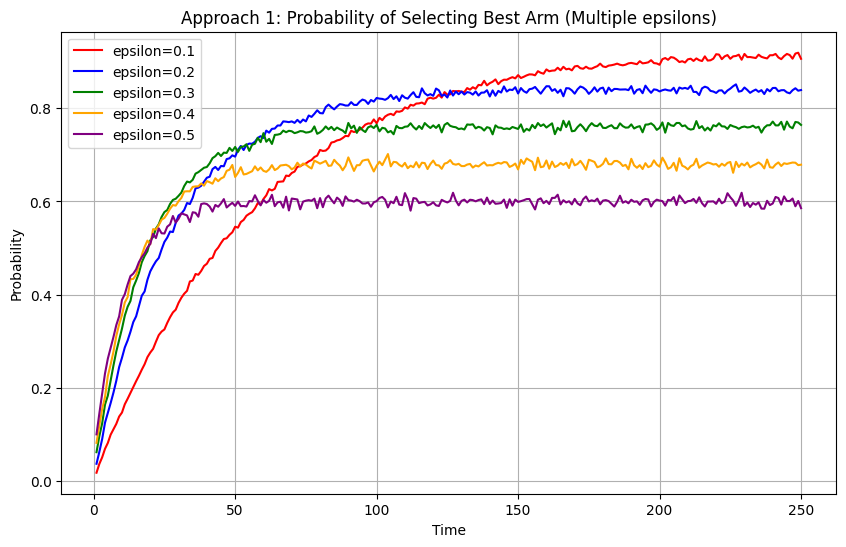

In [26]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ["red", "blue", "green", "orange", "purple"]
horizon = df["time"].max()
num_sims = df["sim_num"].nunique()
best_arm = 2  # 또는 알고리즘 결과로 대체 가능


plt.figure(figsize=(10,6))

for epsilon, color in zip(epsilons, colors):
    subset_df = df[df["epsilon"] == epsilon]

    approach1 = []
    for t in range(1, horizon + 1):
        subset = subset_df[subset_df["time"] == t]
        count = sum(subset["chosen_arm"] == best_arm)
        approach1.append(count / num_sims)

    plt.plot(range(1, horizon + 1), approach1, label=f"epsilon={epsilon}", color=color)

plt.title("Approach 1: Probability of Selecting Best Arm (Multiple epsilons)")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()


- X축: 시간 (pull한 횟수)

- Y축: 최적 arm 선택 확률

- ε=0.1 → 느리게 올라가지만 최종 성능 좋음

- ε=0.5 → 빨리 올라가지만 끝에서는 낮음

→ Explore-Exploit Tradeoff를 잘 보여줌

왜??

어떤 arm이 좋은지 아직 잘 모를 땐 여러 arm을 시도해보는 게 필요한데 (탐색 = Explore),
이미 좋은 arm을 알고 있다면 그 arm만 계속 쓰는 게 보상에는 더 유리함 (활용 = Exploit).

이 두 가지를 어떻게 균형 있게 조절하느냐가 핵심 !!

초반 기울기:
ε가 클수록 많은 arm을 시도하니까 → 처음엔 빠르게 상승함

후반 정확도:
ε가 작을수록 한 arm에 집중하니까 → 최종 정확도는 가장 높아짐

# ✅ Approach 2: Track the Average Reward at Each Point in Time
(각 시간에서 받은 평균 보상 추적)

"지금 이 알고리즘은 평균적으로 얼마나 보상을 받고 있지?"

책 내용 :

각 시간 t에서 보상의 평균을 계산해 성능을 측정함

이 방식은 최적 arm 선택 여부보다는 실제로 얼마나 잘 보상을 얻었는지 보여줌

arm들 간 보상 차이가 작거나 비슷할 때 더 의미 있는 지표임

단점: 개별 보상이 0 또는 1이라서, 경우에 따라선 큰 차이 안 보일 수도 있음

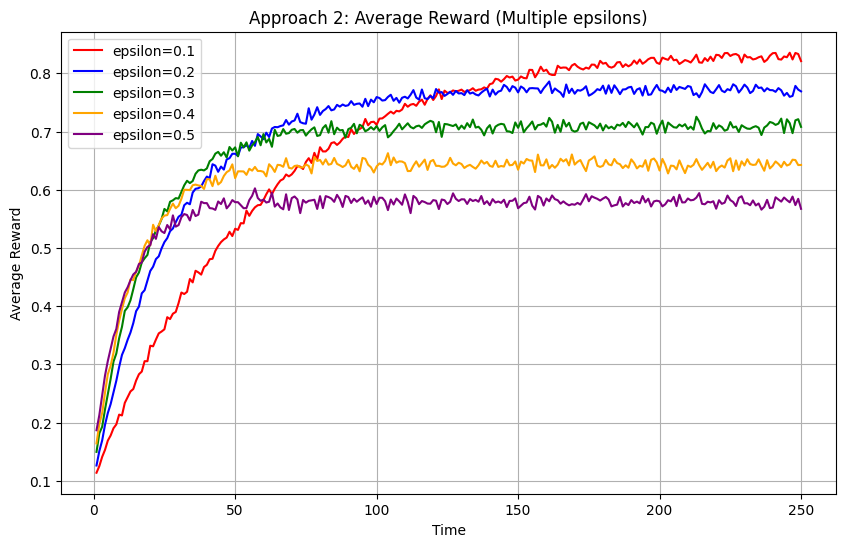

In [27]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ["red", "blue", "green", "orange", "purple"]

horizon = df["time"].max()
num_sims = df["sim_num"].nunique()
best_arm = 2  # 또는 알고리즘 결과로 대체 가능


plt.figure(figsize=(10,6))

for epsilon, color in zip(epsilons, colors):
    subset_df = df[df["epsilon"] == epsilon]

    approach2 = []
    for t in range(1, horizon + 1):
        subset = subset_df[subset_df["time"] == t]
        avg_reward = subset["reward"].mean()
        approach2.append(avg_reward)

    plt.plot(range(1, horizon + 1), approach2, label=f"epsilon={epsilon}", color=color)

plt.title("Approach 2: Average Reward (Multiple epsilons)")
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()

- 모든 epsilon 값의 그래프가 꽤 비슷하게 보일 수 있음 (0/1 reward라서)

- 하지만 평균 보상이 가장 높은 ε=0.1이 결국은 가장 효율적인 탐색 전략

# ✅ Approach 3: Track the Cumulative Reward at Each Point in Time
(누적 보상 추적 → 장기적 성능 평가)



"지금까지 얻은 총 보상은 얼마야?"

책 내용 :

장기적인 관점에서 지금까지 얻은 reward 총합을 본다

초기엔 탐색을 많이 해서 손해보더라도, 장기적으로 좋은 arm을 잘 활용하면 높은 누적 보상을 얻게 됨

그래서 ε 값이 커도 후반부에 잘 올라가는 경우가 있음

탐색이 많은 알고리즘에게 더 공정한 평가 방식

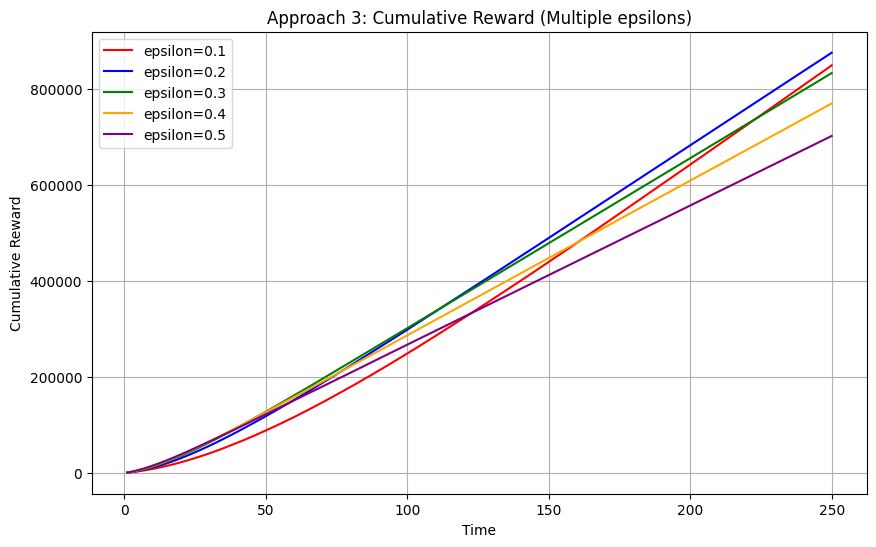

In [28]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ["red", "blue", "green", "orange", "purple"]

horizon = df["time"].max()
num_sims = df["sim_num"].nunique()
best_arm = 2  # 또는 알고리즘 결과로 대체 가능


plt.figure(figsize=(10,6))

for epsilon, color in zip(epsilons, colors):
    subset_df = df[df["epsilon"] == epsilon]

    approach3 = []
    cumulative = 0.0
    for t in range(1, horizon + 1):
        subset = subset_df[subset_df["time"] == t]
        total_reward = subset["reward"].sum()
        cumulative += total_reward  # 누적합
        approach3.append(cumulative)

    plt.plot(range(1, horizon + 1), approach3, label=f"epsilon={epsilon}", color=color)

plt.title("Approach 3: Cumulative Reward (Multiple epsilons)")
plt.xlabel("Time")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()

- 누적 보상은 시간 전체를 고려한 총 보상을 봄

- 초반에 약간 손해 보더라도, 좋은 arm을 잘 찾으면 긴 시간 동안 보상을 더 많이 얻을 수 있음

- ε=0.2처럼 적당한 탐색을 하는 경우,
→ 시간이 지남에 따라 ε=0.1보다 더 높은 누적 보상을 가질 수 있음

- 반대로 ε=0.5처럼 너무 많이 탐색하면,
→ 최적 arm을 잘 활용하지 못해서 누적 보상이 낮게 유지됨

- 이 지표는 전체 성능을 한눈에 보는 데 적합함

# 5월 16일 학부연구생 숙제

## ✅ Step 1: horizon 값을 다르게 실험해서 .tsv 파일 저장
horizon_list = [100, 250, 500] 같은 식으로 반복해서 저장함
파일명도 horizon별로 다르게 저장하기

In [29]:
horizon_list = [100, 250, 500]
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]

for horizon in horizon_list:
    file_path = f"/content/drive/MyDrive/학부연구생 25-1/standard_results_h{horizon}.tsv"
    f = open(file_path, "w")

    for epsilon in epsilons:
        algo = EpsilonGreedy(epsilon, [], [])
        algo.initialize(n_arms)

        results = test_algorithm(algo, arms, 5000, horizon)

        for i in range(len(results[0])):
            f.write(str(epsilon) + "\t")
            f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

    f.close()
    print("저장 완료:", file_path)


저장 완료: /content/drive/MyDrive/학부연구생 25-1/standard_results_h100.tsv
저장 완료: /content/drive/MyDrive/학부연구생 25-1/standard_results_h250.tsv
저장 완료: /content/drive/MyDrive/학부연구생 25-1/standard_results_h500.tsv


## ✅ Step 2: 저장된 파일들을 불러와서 horizon별 그래프 그리기

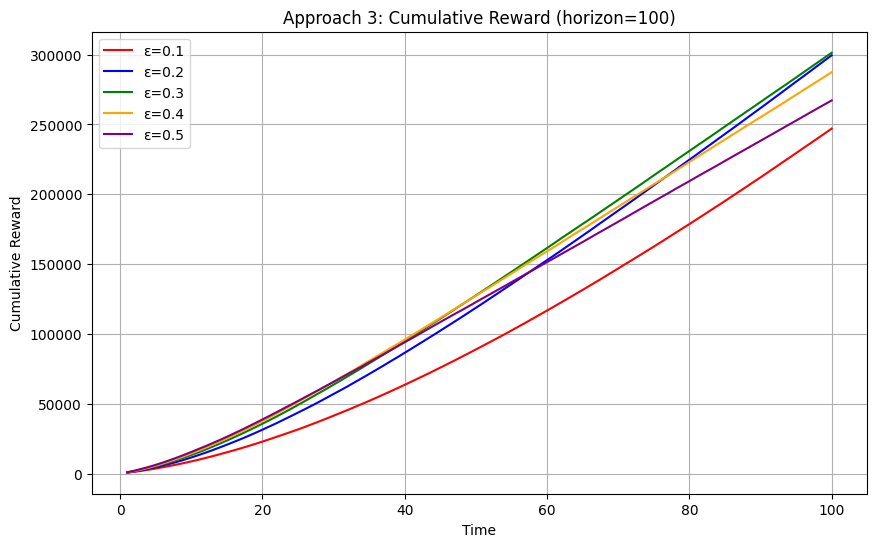

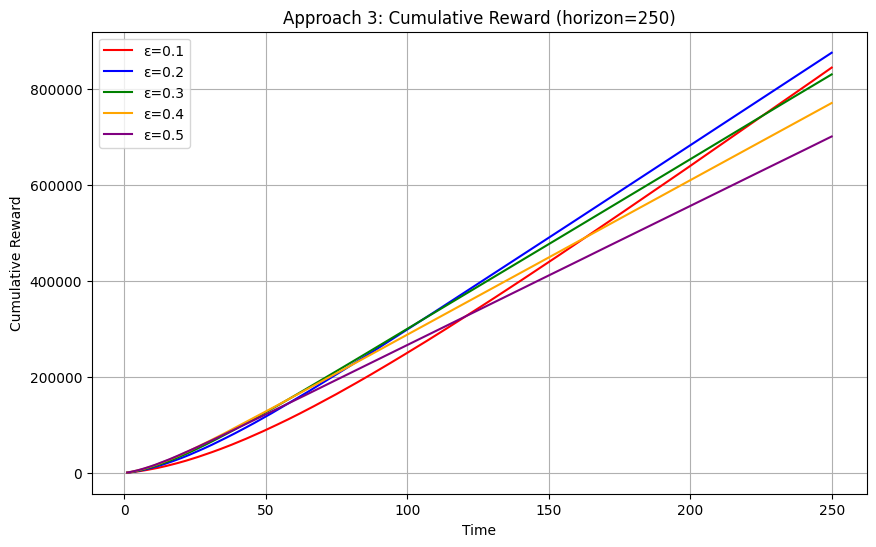

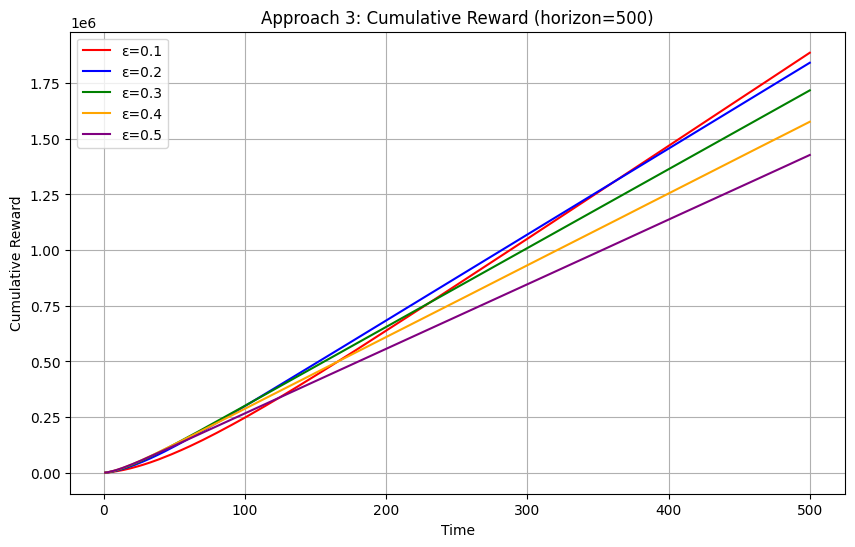

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

horizon_list = [100, 250, 500]
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ["red", "blue", "green", "orange", "purple"]

for horizon in horizon_list:
    file_path = f"/content/drive/MyDrive/학부연구생 25-1/standard_results_h{horizon}.tsv"
    df = pd.read_csv(file_path, sep="\t", header=None)
    df.columns = ["epsilon", "sim", "time", "chosen_arm", "reward", "cumulative_reward"]

    plt.figure(figsize=(10, 6))

    for epsilon, color in zip(epsilons, colors):
        subset_df = df[df["epsilon"] == epsilon]

        approach3 = []
        cumulative = 0.0
        for t in range(1, horizon + 1):
            subset = subset_df[subset_df["time"] == t]
            total_reward = subset["reward"].sum()
            cumulative += total_reward
            approach3.append(cumulative)

        plt.plot(range(1, horizon + 1), approach3, label=f"ε={epsilon}", color=color)

    plt.title(f"Approach 3: Cumulative Reward (horizon={horizon})")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid()
    plt.show()


## ✅ 그래프 요약: Approach 3 – 누적 보상 (Cumulative Reward)
🔍 실험 목적
시간(horizon)이 길어질수록 epsilon 값에 따라 누적 보상 성능 차이가 어떻게 나타나는지 확인하기 위함

✅ 그래프 해석

📊 Horizon = 100
ε=0.3, 0.4, 0.5가 높은 누적 보상을 보임

시간이 짧기 때문에 초반에 빠르게 탐색하는 높은 epsilon들이 유리함

→ “짧은 시간 안에 최대한 다양한 arm을 시도해 보는 게 누적 보상에 이롭다”

📊 Horizon = 250
ε=0.2가 가장 우수하고, ε=0.1도 뒤따름

시간이 조금 더 길어지자 과한 탐색(ε=0.5)은 불리해지기 시작

→ “어느 정도 시간 여유가 있으면, 지나친 탐색보다는 적당한 exploit이 효율적이다”

📊 Horizon = 500
ε=0.1이 명확하게 가장 높은 누적 보상 달성

ε=0.2도 비슷하게 우수, 반면 ε=0.5는 가장 낮은 보상

→ “긴 시간(horizon)이 보장되면, 적은 탐색 + 많은 exploit이 가장 효과적이다”

### ✅ 누적 보상 비교 (Approach 3)

- **Horizon=100**: ε=0.3~0.5가 유리 → 초반 탐색이 효과적
- **Horizon=250**: ε=0.2가 가장 좋음 → 적당한 탐색 + exploit
- **Horizon=500**: ε=0.1이 최고 성능 → 최적 arm을 잘 활용한 결과

➡ Explore-exploit tradeoff가 시간 길이에 따라 어떻게 변화하는지 명확히 보임
➡ Horizon이 길수록 작은 ε이 장기 성능에 유리

## ✅ Horizon 1000 실험 준비 방법
horizon=1000으로 test_algorithm 돌려서 standard_results_h1000.tsv 저장

기존 그래프 그리는 코드에 1000 추가해서 시각화

In [31]:
horizon = 1000
file_path = "/content/drive/MyDrive/학부연구생 25-1/standard_results_h1000.tsv"
f = open(file_path, "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)

    results = test_algorithm(algo, arms, 5000, horizon)

    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()
print("저장 완료:", file_path)


저장 완료: /content/drive/MyDrive/학부연구생 25-1/standard_results_h1000.tsv


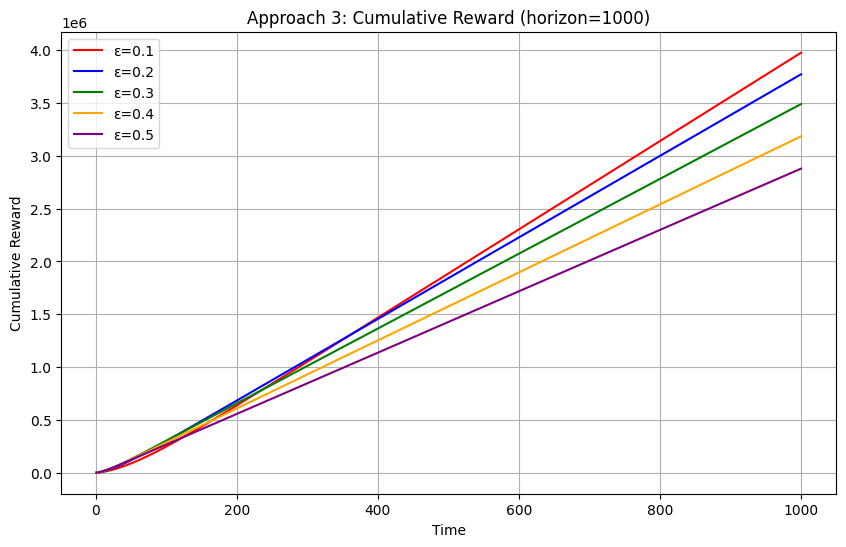

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 데이터 불러오기
file_path = "/content/drive/MyDrive/학부연구생 25-1/standard_results_h1000.tsv"
df = pd.read_csv(file_path, sep="\t", header=None)
df.columns = ["epsilon", "sim_num", "time", "chosen_arm", "reward", "cumulative_reward"]

horizon = df["time"].max()
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ["red", "blue", "green", "orange", "purple"]

# ✅ 그래프 그리기
plt.figure(figsize=(10,6))

for epsilon, color in zip(epsilons, colors):
    subset_df = df[df["epsilon"] == epsilon]

    approach3 = []
    cumulative = 0.0
    for t in range(1, horizon + 1):
        subset = subset_df[subset_df["time"] == t]
        total_reward = subset["reward"].sum()
        cumulative += total_reward
        approach3.append(cumulative)

    plt.plot(range(1, horizon + 1), approach3, label=f"ε={epsilon}", color=color)

plt.title("Approach 3: Cumulative Reward (horizon=1000)")
plt.xlabel("Time")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()


### ✅ Approach 3: Cumulative Reward (horizon=1000)

- **ε=0.1**이 명확한 최종 승자 → 초반에 학습 후 최적 arm만 반복
- **ε=0.2~0.3**도 준수하지만, 탐색이 많을수록 손해
- **ε=0.5**는 끝까지 무작위 선택에 가까워 누적 보상이 가장 낮음

➡ Horizon이 충분히 길어지면, **작은 ε 값이 누적 성능에서 우세**  
➡ 장기적 관점에서 exploit이 많은 전략이 확실히 유리함

# ✅ 최종 정리: Epsilon-Greedy 실험 및 분석

- Bernoulli arm을 구성하여 확률적으로 보상을 주는 환경을 설정함
- 다양한 epsilon 값(0.1, 0.2, 0.3, 0.4, 0.5)으로 Epsilon-Greedy 알고리즘 실험을 진행함
- 실험 결과를 .tsv 파일로 저장하고, 이를 분석하여 그래프를 그림

- Approach 1: 최적 arm 선택 확률을 추적함
- Approach 2: 평균 보상을 추적함
- Approach 3: 누적 보상을 추적함

- 최적 arm 선택 확률은 ε=0.1이 가장 높게 나타남
- 평균 보상은 ε=0.1, 0.2가 우수하게 나타남
- 누적 보상은 시간이 지남에 따라 ε=0.2가 ε=0.1을 초과하는 결과를 보임

- 적절한 탐색(exploration)이 장기적인 성능 향상에 도움이 됨을 확인함
- 탐색과 활용(exploitation)의 균형이 Bandit 문제 해결의 핵심 전략임을 확인함

# Exercise

##  Exercise 1: NormalArm 만들기
- BernoulliArm 클래스를 수정하여, 평균(mean)과 분산(variance)을 가지는 정규분포에서 샘플링된 보상을 반환하도록 변경함.

In [ ]:
# Exercise 1: NormalArm 클래스
import random

class NormalArm():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def draw(self):
        return random.gauss(self.mu, self.sigma)

In [ ]:
#  결과 나오게 사용해보기
arm = NormalArm(mu=5.0, sigma=2.0)

# 정규분포에서 샘플 5개 뽑아보기
for _ in range(5):
    print(arm.draw())

6.087999748480296
6.294731767874817
3.8889073976944513
0.9887282559654444
5.290515559070871


##  Exercise 2: 평균 보상 곡선 추가
- `test_algorithm` 결과를 이용해, 시간에 따른 평균 보상을 계산하고,  
이를 그래프로 시각화하는 함수를 작성함.

In [ ]:
# Exercise 2: 평균 보상 그래프 그리는 함수
def plot_average_reward(results, num_sims, horizon):
    [sim_nums, times, chosen_arms, rewards, cumulative_rewards] = results

    avg_rewards = []
    for t in range(1, horizon + 1):
        total = 0.0
        for s in range(num_sims):
            idx = (s * horizon) + (t - 1)
            total += rewards[idx]
        avg_rewards.append(total / num_sims)

    plt.figure(figsize=(8,5))
    plt.plot(range(1, horizon + 1), avg_rewards)
    plt.xlabel("Time")
    plt.ylabel("Average Reward")
    plt.title("Average Reward over Time")
    plt.grid()
    plt.show()

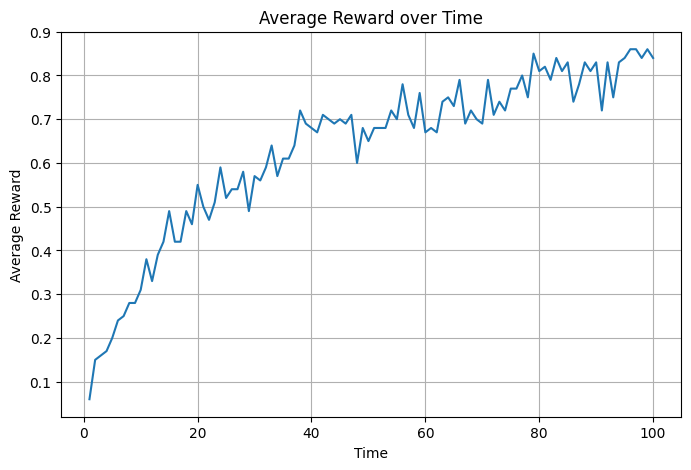

In [ ]:
# 결과 나오게 사용해보기

# 예시 실험을 위한 BernoulliArm과 EpsilonGreedy 정의
class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

# 간단한 실험 함수
def test_algorithm(algo, arms, num_sims, horizon):
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = [], [], [], [], []
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total_reward = 0.0
        for t in range(horizon):
            sim_nums.append(sim)
            times.append(t)
            chosen_arm = algo.select_arm()
            reward = arms[chosen_arm].draw()
            algo.update(chosen_arm, reward)
            total_reward += reward
            chosen_arms.append(chosen_arm)
            rewards.append(reward)
            cumulative_rewards.append(total_reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

# 실험 세팅
arms = [BernoulliArm(0.1), BernoulliArm(0.5), BernoulliArm(0.9)]
algo = EpsilonGreedy(0.1, [], [])
results = test_algorithm(algo, arms, 100, 100)

# 평균 보상 곡선 그리기
plot_average_reward(results, 100, 100)

##  Exercise 3: epsilon을 줄이는 EpsilonGreedy 클래스 만들기
- `EpsilonGreedy` 클래스를 수정하여, 시간이 지남에 따라 epsilon을 감소시키는 함수(decay function)를 매개변수로 받을 수 있도록 변경함.


In [ ]:
# Exercise 3: EpsilonGreedyDecay 클래스
class EpsilonGreedyDecay():
    def __init__(self, epsilon, counts, values, decay_function=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        self.decay_function = decay_function

    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        import random
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

        if self.decay_function is not None:
            self.epsilon = self.decay_function(self.epsilon)

In [ ]:
# decay 함수 예시
def decay(epsilon):
    return max(0.01, epsilon * 0.99)  # 매 업데이트마다 epsilon을 1% 감소

#  결과 나오게 사용해보기
algo = EpsilonGreedyDecay(0.5, [], [], decay)
algo.initialize(5)

print(f"초기 epsilon: {algo.epsilon}")

# 5번 update를 해보면서 epsilon이 줄어드는 걸 확인
for _ in range(5):
    algo.update(0, 1.0)  # dummy update
    print(f"업데이트 후 epsilon: {algo.epsilon}")

초기 epsilon: 0.5
업데이트 후 epsilon: 0.495
업데이트 후 epsilon: 0.49005
업데이트 후 epsilon: 0.48514949999999996
업데이트 후 epsilon: 0.480298005
업데이트 후 epsilon: 0.47549502494999996


의도/목적 ??

초반엔 탐색(explore)을 많이 하고,
후반엔 활용(exploit)을 많이 하고 싶을 때 쓰는 전략!

ε을 고정하지 않고 점점 줄이게 만들면
초반 탐색 → 후반 집중 전략이 가능해짐